In [1]:
%%capture output
! pip install ibllib
! pip install pynapple
! pip install git+https://github.com/int-brain-lab/paper-brain-wide-map.git
! pip install -U google-colab

In [1]:
# system
from pathlib import Path
from tqdm import tqdm
import pickle

# analysis
import numpy as np
import pandas as pd
import pynapple as nap

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# set the IBL style for figures
from ibl_style.style import figure_style
figure_style()

# Accessing the IBL brainwide map dataset

[Companion Slides Here](https://docs.google.com/presentation/d/1hLR4_Yyuv11QsxAuBertRARs3qvncl9-NApt0vmqmsk/edit#slide=id.p1)

The IBL brainwide map dataset ([biorxiv preprint](https://www.biorxiv.org/content/10.1101/2023.07.04.547681v2)) consists of more that 62k units, distributed over the entire brain, recorded from over 100 mice in over 400 sessions. It is publicly accessible via `ONE`.

## A minimal `ONE` primer
`ONE` is the _Open Neurophysiology Environment_, a framework for accessing and sharing data acquired in neurophysiology experiments.

+ [main documentation and tutorial](https://int-brain-lab.github.io/ONE/one_reference.html)

+ [in depth colab notebook](https://colab.research.google.com/drive/1y3sRI1wC7qbWqN6skvulzPOp6xw8tLm7)

+ [github repository](https://github.com/int-brain-lab/ONE)

### `ONE` and `Alyx`
`ONE` works on top of `Alyx`, a relational database that hosts and relates all experimental metadata, as well as links to the storage location of the individual datasets.

+ [main documentation](https://alyx.readthedocs.io/en/latest/index.html)

+ [github repository](https://github.com/cortex-lab/alyx)

For this tutorial, we will work mostly with objects and access function that make most of the functionality available in simple and abstracted ways.

## Configuring and instantiating `ONE`
The `ONE` object can be instantiated in many different ways to work in different modes (online / local), you can find more information here [here](https://int-brain-lab.github.io/ONE/one_installation.html)

In [2]:
from one.api import ONE

one_kwargs = dict(
    base_url='https://openalyx.internationalbrainlab.org',
    username='intbrainlab',
    password='international',
    silent=True,
)
one = ONE(**one_kwargs)

## Essential concepts for working with `ONE`

### Concept: experiment id (`eid`), probe id (`pid`) and probe name

+ Each experiment has it's own and unique id, and all data that is associated to that experiment can by accessed by using this id, in code often abbreviated by `eid`.

+ Each inserted probe has a `pid`. For a dual neuropixel recording, there are thus two `pid` associated to one `eid`. Like the `eid`, a `pid` is a unique identifier.

+ Each inserted probe has a name, which is always an `probe00` or `probe01`.

These ids and names can be converted into each other with `one.eid2pid()` and `one.pid2eid()` and we will need to use both to access the data from the IBL brainwide map.

In [5]:
# this is just an example eid
# we will see how to get eids in a moment further down
eid = "c7bd79c9-c47e-4ea5-aea3-74dda991b48e"

pids, pnames = one.eid2pid(eid)
print(pids, pnames)

[UUID('675952a4-e8b3-4e82-a179-cc970d5a8b01'), UUID('79f44ba1-c931-4346-82eb-f628a9374045')] ['probe01', 'probe00']


In [6]:
pid = pids[0]
eid, pname = one.pid2eid(pid)
print(eid, pname)

c7bd79c9-c47e-4ea5-aea3-74dda991b48e probe01


## Getting `eid`s for the brainwide map dataset
The brainwide map dataset is just a fraction of the data that can be openly accessed via `ONE`. See [here](https://int-brain-lab.github.io/ONE/notebooks/one_search/one_search.html) for some more in depth guide on how to search for datasets openly accesible via `ONE`.

A great way to have an interactive overview of the datasets is to visit the IBL viz app here:
[viz.internationalbrainlab.org/app](https://viz.internationalbrainlab.org/app?spikesorting=ss_2024-05-06)


To get the full table of the brainwide map dataset programmatically, one can use the summary tables present in the module `brainwidemap`
[github repository](https://github.com/int-brain-lab/paper-brain-wide-map)


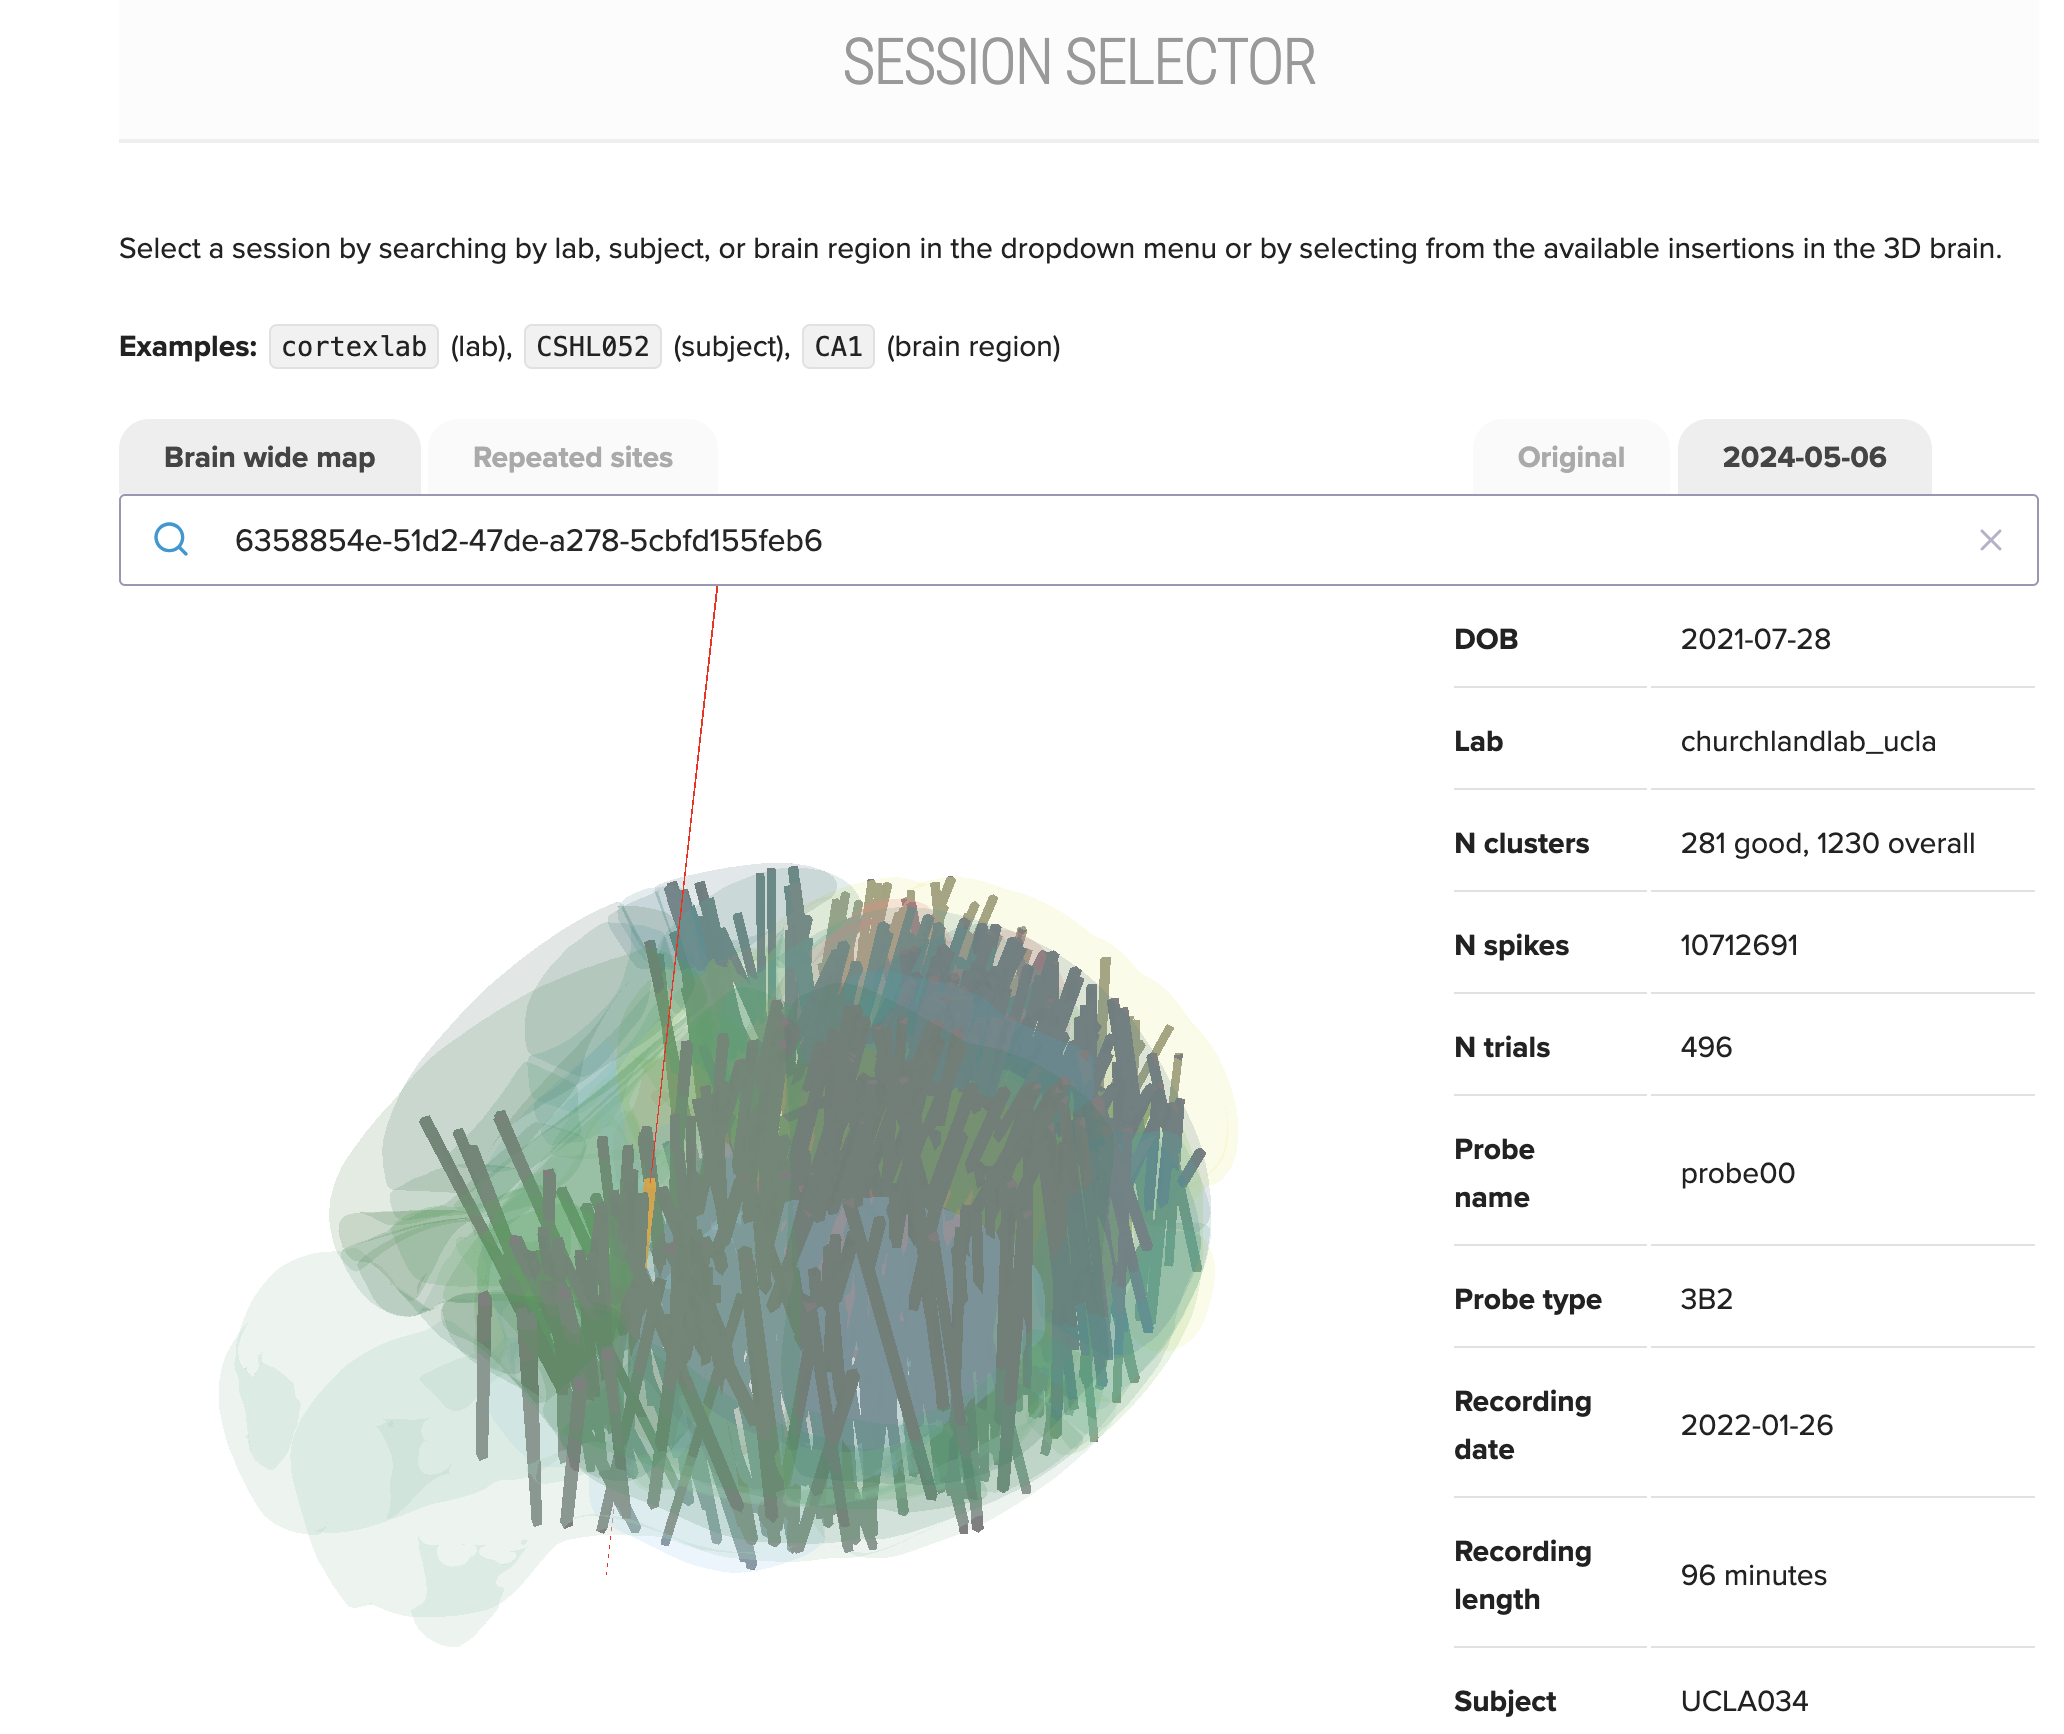


In [3]:
import brainwidemap
# this dataframe holds a summary of all the sessions
# and for us importantly, the eids and pids
bwm_df = brainwidemap.bwm_query()  # each row of this dataframe is a recording

n_sessions = bwm_df["eid"].unique().shape[0]
n_insertions = bwm_df["pid"].unique().shape[0]
print(
    f"{n_sessions} sessions with {n_insertions} individual neuropixel recordings"
)
bwm_df.head()

Loading bwm_query results from fixtures/2023_12_bwm_release.csv
459 sessions with 699 individual neuropixel recordings


,pid,eid,probe_name,session_number,date,subject,lab
0,56f2a378-78d2-4132-b3c8-8c1ba82be598,6713a4a7-faed-4df2-acab-ee4e63326f8d,probe00,1,2020-02-18,NYU-11,angelakilab
1,47be9ae4-290f-46ab-b047-952bc3a1a509,56956777-dca5-468c-87cb-78150432cc57,probe01,1,2020-02-21,NYU-11,angelakilab
2,6be21156-33b0-4f70-9a0f-65b3e3cd6d4a,56956777-dca5-468c-87cb-78150432cc57,probe00,1,2020-02-21,NYU-11,angelakilab
3,8dfb86c8-d45c-46c4-90ec-33078014d434,4364a246-f8d7-4ce7-ba23-a098104b96e4,probe01,1,2020-01-20,NYU-12,angelakilab
4,c893c0a3-5597-49cf-baa1-60efdfdef542,b182b754-3c3e-4942-8144-6ee790926b58,probe01,1,2020-01-21,NYU-12,angelakilab


## Getting units from the brainwide map

Likewise, another helper function gives you access to all the units in the brainwide map. This table gathers a lot of important metadata:
+ brain region and localization
+ single cell quality metrics
+ `eid` and `pid` of the recording

In [4]:
units_df = brainwidemap.bwm_units(one)
n_units = units_df.shape[0]
print(f"{n_units} units present in the table")
units_df

Loading bwm_query results from fixtures/2023_12_bwm_release.csv
d16d0b38d392b18c0ce8b615ec89d60d7c901df2eeb3432986b62130af28ef01
62990 units present in the table


,Beryl,eid,channels,depths,uuids,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,...,ks2_label,x,y,z,acronym,atlas_id,axial_um,lateral_um,pid,spike_count_good
0,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,61,620.0,c5cabbda-1f74-4168-ad5e-7c5a2f533d9f,79,0.000300,0.000081,0.000158,1.056608,...,good,-0.002378,-0.000250,-0.006350,CNU,23,620.0,11.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,167762.0
1,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,68,700.0,5b5176f2-228f-46b5-85c8-205cf9d90a53,88,0.000323,0.000123,0.000221,0.972567,...,good,-0.002364,-0.000250,-0.006272,CNU,23,700.0,43.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,16139.0
2,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,71,720.0,19930b44-2f8a-44e1-a8ce-46184f7334cb,91,0.000187,0.000057,0.000109,1.266665,...,good,-0.002364,-0.000250,-0.006252,CNU,23,720.0,27.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,34700.0
3,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,77,780.0,304c2251-f207-4926-ba28-967ebbda4473,105,0.000208,0.000046,0.000079,1.655816,...,good,-0.002364,-0.000250,-0.006192,CNU,23,780.0,11.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,224475.0
4,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,82,840.0,4bd714b8-5753-4561-87e5-2ef3126426b7,115,0.000346,0.000085,0.000163,1.334542,...,good,-0.002364,-0.000250,-0.006132,CNU,23,840.0,59.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,292062.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62985,x,810b1e07-009e-4ebe-930a-915e4cd8ece4,55,560.0,3beabe91-423a-49c3-8e55-fb846457c89d,152,0.000258,0.000093,0.000139,1.890024,...,good,-0.001714,-0.006287,-0.004645,HB,765,560.0,27.0,c5fd185f-1c5a-4aad-9795-43c4ccf8ea94,2307.0
62986,x,810b1e07-009e-4ebe-930a-915e4cd8ece4,57,580.0,78952ffb-d419-464e-96e9-2b22723aa58b,158,0.000910,0.000085,0.000170,3.049439,...,good,-0.001725,-0.006281,-0.004621,HB,765,580.0,11.0,c5fd185f-1c5a-4aad-9795-43c4ccf8ea94,544566.0
62987,x,810b1e07-009e-4ebe-930a-915e4cd8ece4,54,560.0,2490ff61-baae-4e8e-a90e-d34e851b8cd1,160,0.000213,0.000069,0.000119,1.654493,...,good,-0.001714,-0.006287,-0.004645,HB,765,560.0,59.0,c5fd185f-1c5a-4aad-9795-43c4ccf8ea94,37240.0
62988,x,810b1e07-009e-4ebe-930a-915e4cd8ece4,58,600.0,945e9b3b-0a09-4272-b56e-7640e1e1f647,161,0.000247,0.000070,0.000109,1.398105,...,good,-0.001735,-0.006276,-0.004598,HB,765,600.0,59.0,c5fd185f-1c5a-4aad-9795-43c4ccf8ea94,37519.0


## Example: loading a recording with spikes from a given brain region

Lets get a recording where the probe was inserted into our favourite brain area. The simplest way is to access the 'Beryl' column of the `units_df` dataframe and use it to select units

In [9]:
units_df['Beryl'].unique()

array(['AAA', 'ACAd', 'ACAv', 'ACB', 'AD', 'AId', 'AIp', 'AIv', 'AM',
       'ANcr1', 'ANcr2', 'AON', 'APN', 'APr', 'AUDd', 'AUDp', 'AUDpo',
       'AUDv', 'AV', 'BLA', 'BMA', 'BST', 'CA1', 'CA2', 'CA3', 'CEA',
       'CENT2', 'CENT3', 'CL', 'CLA', 'CLI', 'CM', 'COAp', 'COPY', 'CP',
       'CS', 'CU', 'CUL4 5', 'CUN', 'DCO', 'DEC', 'DG', 'DN', 'DP', 'DR',
       'ECT', 'ECU', 'ENTl', 'ENTm', 'EPd', 'EPv', 'Eth', 'FC', 'FL',
       'FOTU', 'FRP', 'FS', 'GPe', 'GPi', 'GRN', 'GU', 'HATA', 'I5', 'IA',
       'IAD', 'IC', 'ICB', 'IGL', 'ILA', 'IP', 'IRN', 'LA', 'LAV', 'LD',
       'LDT', 'LGd', 'LGv', 'LH', 'LHA', 'LING', 'LP', 'LPO', 'LRN',
       'LSc', 'LSr', 'LSv', 'MA', 'MARN', 'MD', 'MDRN', 'MEA', 'MG', 'MH',
       'MOB', 'MOp', 'MOs', 'MPO', 'MRN', 'MS', 'MV', 'NB', 'NDB', 'NLL',
       'NOD', 'NOT', 'NPC', 'NTS', 'OP', 'ORBl', 'ORBm', 'ORBvl', 'OT',
       'P5', 'PA', 'PAA', 'PAG', 'PAR', 'PARN', 'PB', 'PBG', 'PC5', 'PCG',
       'PCN', 'PF', 'PFL', 'PGRN', 'PH', 'PIR', 'PL', 'PO',

The column `Beryl` denotes brain atlas annotations without layer sub-divisions or certain ganglial/nucleus sub-devisisions (e.g. the core/shell sub-division of the lateral geniculate nucleus). Fibre tracts, pia, etc. are also absent.

However, there are many other ways to group brain areas. The Allen CCF defines a brain region hierarchy:



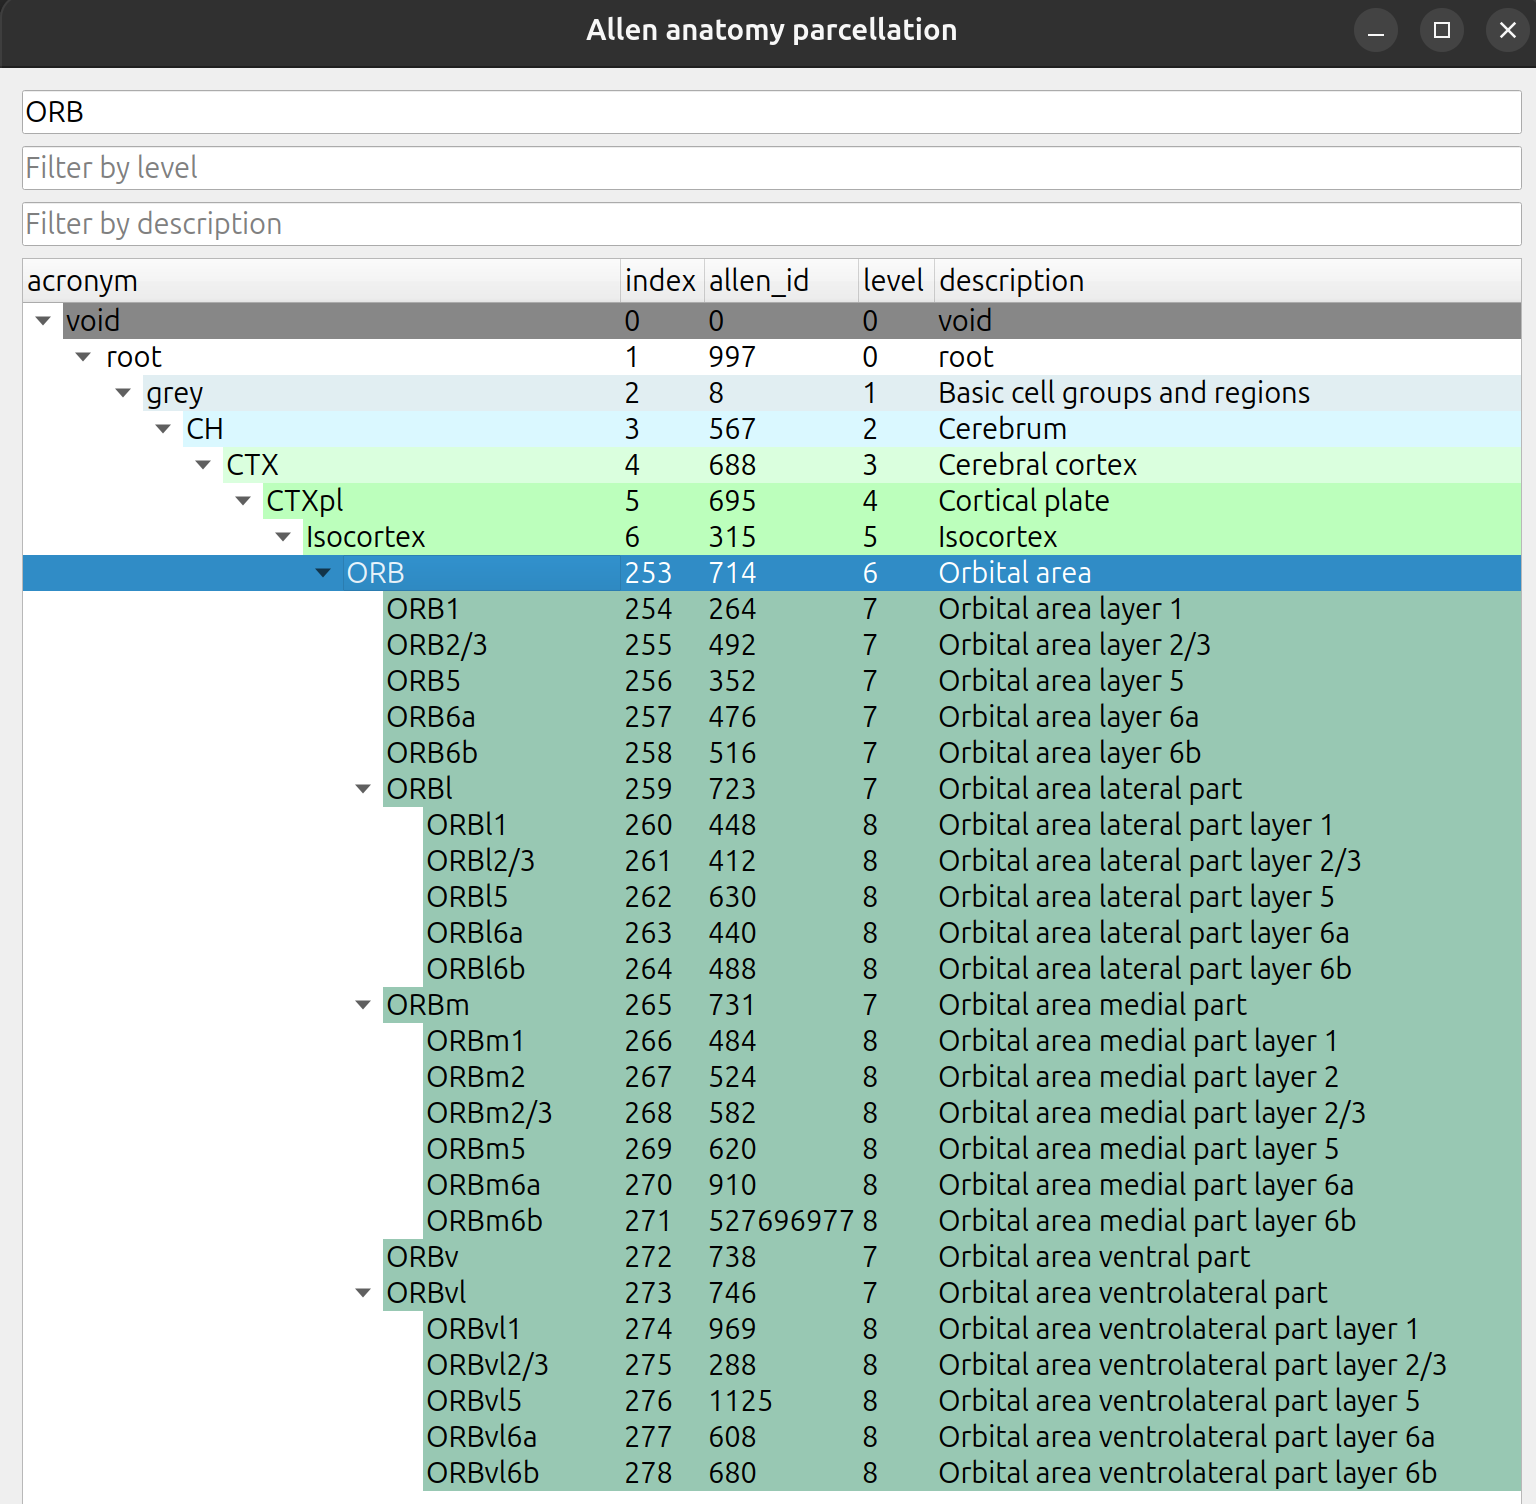

The module `iblatlas` offers access functions for navigating this hierachy.

+ [Documentation](https://int-brain-lab.github.io/iblenv/_autosummary/iblatlas.html)

+ [Examples](https://int-brain-lab.github.io/iblenv/notebooks_external/atlas_working_with_ibllib_atlas.html)

+ [Github repository](https://github.com/int-brain-lab/iblatlas)



In [5]:
area = "CA1"
from iblatlas.atlas import BrainRegions
regions = BrainRegions()

# convert acronym to Allen unique atlas id
atlas_id = regions.acronym2id(acronym=area)

# get all the ids of descendant brain areas
atlas_ids = regions.descendants(atlas_id)['id']

# a boolean vector to index
ix = units_df['atlas_id'].isin(atlas_ids)

units_df_ = units_df.loc[ix]
print(f"{units_df_.shape[0]} units for brain area {area}")

1715 units for brain area CA1


# Spike trains analysis

In this example we will look at insertions within the Anterior Cingulate Cortex, and display the activity of one Unit.

We will look at raster maps for each trial, centered on the stimulus onset, for different task conditions:


*   Absolute contrast: 0%, 6.25%, 12.5% 25% and 100%
*   Trial outcome: correct / incorrect

The first step is to define helper functions


In [6]:
# Here we repeat the imports and instantiate ONE, so this cell can also be run stand-alone
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

from iblutil.numerical import bincount2D
from iblatlas.atlas import BrainRegions
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader, SessionLoader
from ibl_style.style import figure_style

figure_style()  # set the style for IBL figures

one_kwargs = dict(
    base_url='https://openalyx.internationalbrainlab.org',
    username='intbrainlab',
    password='international',
    silent=True,
)
one = ONE(**one_kwargs)

def psth_indices(times, t_events, fs=None, event_window=np.array([-1, 1])):
    """
    Compute the peri-event time indices
    :param signal:
    :param times:
    :param t_events:
    :param fs:
    :param event_window:
    :return: idx_psth: (nc, nt), tscale
    """
    event_window = np.array(event_window)
    if fs is None:
        fs = 1 / np.nanmedian(np.diff(times))
    # compute a vector of indices corresponding to the perievent window at the given sampling rate
    sample_window = np.round(
        np.arange(event_window[0] * fs, event_window[1] * fs + 1)
    ).astype(int)
    # we inflate this vector to a 2d array where each column corresponds to an event
    idx_psth = np.tile(sample_window[:, np.newaxis], (1, t_events.size))
    # we add the index of each event too their respective column
    idx_event = np.searchsorted(times, t_events)
    idx_psth += idx_event
    # here we handle the case where the event window is outside of the initial boundaries
    i_out_of_bounds = np.logical_or(idx_psth > (times.size - 1), idx_psth < 0)
    idx_psth[i_out_of_bounds] = -1
    return idx_psth, sample_window.astype(float) / fs


def compute_binned_psths(st, sc, t_events, dt=0.02, event_window=np.array([-1, 1])):
    raster, t_scale, c_scale = bincount2D(st, sc, xbin=dt)
    ipsth, tscale = psth_indices(t_scale, t_events=t_events, event_window=event_window)
    return raster[:, ipsth], tscale  # (nc, nt, ne)


## Querying and loading the data

Then we will query the brain region ACA. ACA has many sub-regions, and we need to get the list of neurons belinging to any of the sub-regions.

In [7]:
# Here we perform the brain region query on ACA.
pids = one.search_insertions(atlas_acronym='CA1', datasets='spikes.times.npy', project='brainwide')
regions = BrainRegions()
aca_leaf_nodes = regions.descendants(regions.acronym2id('CA1'))
print(f"List of regions to query: \n {aca_leaf_nodes['acronym']}")


List of regions to query: 
 ['CA1' 'CA1slm' 'CA1so' 'CA1sp' 'CA1sr']


In [9]:
# We will display a window of -1 / +1 secs around the Stimulus Onset
event_window = [-1, 1]
pid =pids[9]

# Here we load the spikes and the trials has we have seen before. Here we load only the units passing the quality control
ssl = SpikeSortingLoader(one=one, pid=pid)
spikes, clusters, channels = ssl.load_spike_sorting(good_units=True, revision='2025-05-26')
df_clus = pd.DataFrame(ssl.merge_clusters(spikes, clusters, channels))
sl = SessionLoader(one=one, eid=ssl.eid)
sl.load_trials()
# For the trials, it is handy to create a column that contains the absolute contrast
sl.trials['ucontrast'] = np.nanmean(np.stack((sl.trials['contrastLeft'], sl.trials['contrastRight'])), axis=0)

# This is were we select the units belonging to any of the leaf nodes brain regions
selection_clusters = df_clus['atlas_id'].isin(aca_leaf_nodes['id'])
iclusters = np.where(selection_clusters)[0]
# We extend the selection to the spikes that belong to the selected clusters
ispikes = np.isin(spikes['clusters'], iclusters)
st = spikes['times'][ispikes]
sc = spikes['clusters'][ispikes]
# We compute the PSTHs
psths, tscale = compute_binned_psths(st, sc, t_events=sl.trials['stimOn_times'].values, event_window=event_window)  # (nc, nt, ne)

# plot_rasters(2)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


## Display a raster plot aligned to Stimulus Onset

Here we will select a unit and display a few raster plot.

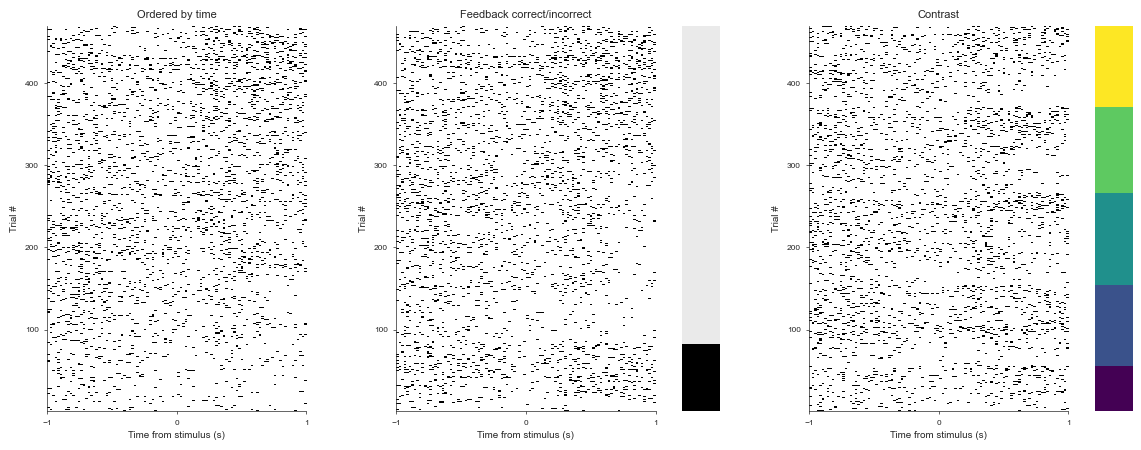

In [10]:
ic = 2  # selected cluster

# Here we create a figure with axes for the raster and also for behaviour conditions
fig, ax = plt.subplots(ncols=7, gridspec_kw={'width_ratios': [7, 1, 7, 1, 1, 7, 1], 'hspace': 0}, figsize=(14, 5))

# those keyword arguments will be passed to all matshow raster calls
mshow_kwargs = dict(extent=[event_window[0], event_window[1], 1, sl.trials.shape[0]], vmin=0, vmax=1)

# for the left plot we keep the raster sorted in time
ax[0].matshow(psths[ic, :, :].T, aspect='auto', cmap='Greys', origin='lower', **mshow_kwargs)

# the middle plot will have the raster sorted by outcome, and we annotate the outcome as a sidebar
iordre = np.lexsort([sl.trials['feedbackType'].to_numpy()])
ax[2].matshow(psths[ic, :, iordre], aspect='auto', cmap='Greys', origin='lower', **mshow_kwargs)
ax[3].matshow(np.atleast_2d(sl.trials['feedbackType'].to_numpy()[iordre]).T, aspect='auto', cmap='Greys_r', origin='lower',  vmin=-.1, vmax=1.2)

# the right plot will have the raster sorted by contrast, and we annotate the contrast as a sidebar
iordre = np.lexsort([ sl.trials['ucontrast'].to_numpy()])
ax[5].matshow(psths[ic, :, iordre], aspect='auto', cmap='Greys', origin='lower', **mshow_kwargs)
_, uc = np.unique(sl.trials['ucontrast'].to_numpy()[iordre], return_inverse=True)
ax[6].matshow(np.atleast_2d(uc).T, aspect='auto', cmap='viridis', origin='lower')

# label the axis and other cosmetic calls
ax[0].set(xlabel='Time from stimulus (s)', ylabel='Trial #', title='Ordered by time')
ax[2].set(xlabel='Time from stimulus (s)', ylabel='Trial #', title='Feedback correct/incorrect')
ax[5].set(xlabel='Time from stimulus (s)', ylabel='Trial #', title='Contrast')
_ = [ax[i].axis('off') for i in [1, 3, 4, 6]]
_ = [ax[i].xaxis.set_ticks_position('bottom') for i in [0, 2, 5]]


Interesting patterns emerge depending on how we sort the data:


*  by time (ie. unsorted), here we can hypothesize about engagement and satiety as there is a slight decay over time
*  by feedback outcome: correct / incorrect: the cell responds more to correct trials
* by contrast value 0%, 6.25%, 12.5% 25% and 100%: the cell responds more to higher contrasts

## Display the Corresponding PSTHs

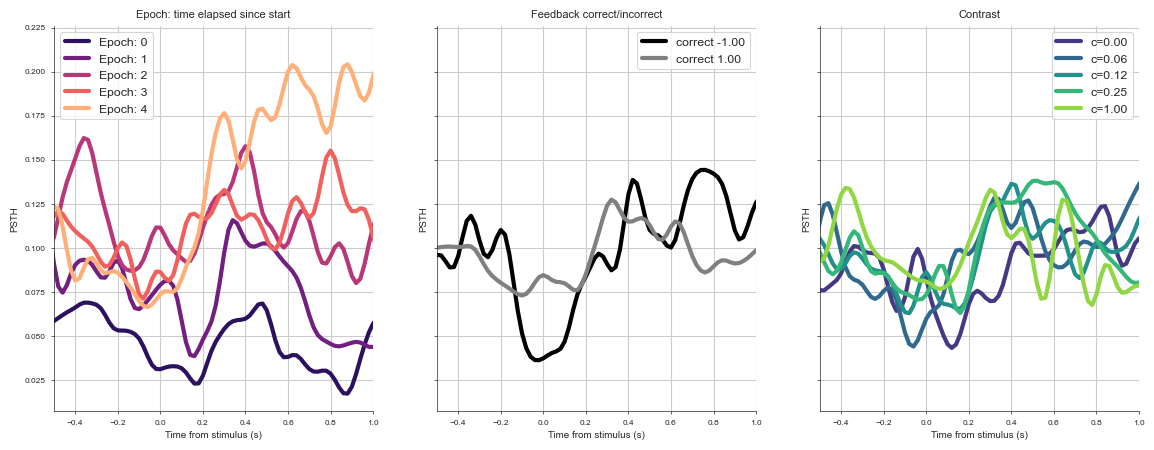

In [11]:
# we will display the corresponding PSTHs for the rasters above
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=[14, 5])
contrasts = np.sort(sl.trials['ucontrast'].unique())
colors = sns.color_palette("viridis", n_colors=contrasts.shape[0])
contrast_colors = dict(zip(contrasts, colors))
sigma_smooth = 2
ax_set_kwargs = dict(xlabel='Time from stimulus (s)', xlim=[-0.5, 1])

# For the first, we will aggregate per "epochs", quantiles of time elapsed since session start
n_epoch = 5
epoch_colors = sns.color_palette('magma', n_colors=n_epoch)
sl.trials['epoch'] = pd.qcut(sl.trials['intervals_0'], q=n_epoch, labels=np.arange(n_epoch))
for epoch, trials in sl.trials.groupby("epoch",  observed=True):
    spikes_bin = np.sum(psths[ic, :, trials.index.values], axis=0) / trials.shape[0]
    spikes_bin = scipy.ndimage.gaussian_filter1d(spikes_bin, sigma_smooth, mode='reflect')
    ax[0].plot(tscale, spikes_bin, lw=3, color=epoch_colors[epoch], label=f"Epoch: {epoch}")
ax[0].legend()
ax[0].grid(True)
ax[0].set(ylabel='PSTH', title='Epoch: time elapsed since start', **ax_set_kwargs)

# The middle plot is the feedback outcome, correct / incorrect
for outcome, trials in sl.trials.groupby("feedbackType"):
    spikes_bin = np.sum(psths[ic, :, trials.index.values], axis=0) / trials.shape[0]
    spikes_bin = scipy.ndimage.gaussian_filter1d(spikes_bin, sigma_smooth, mode='reflect')
    ax[1].plot(tscale, spikes_bin, color='gray' if outcome == 1 else'black', lw=3, label=f"correct {outcome:.2f}")
ax[1].legend()
ax[1].grid(True)
ax[1].set(ylabel='PSTH', title='Feedback correct/incorrect', **ax_set_kwargs)

# The right plot is the contrast plot
for contrast, trials in sl.trials.groupby("ucontrast"):
    spikes_bin = np.sum(psths[ic, :, trials.index.values], axis=0) / trials.shape[0]
    spikes_bin = scipy.ndimage.gaussian_filter1d(spikes_bin, sigma_smooth, mode='reflect')
    ax[2].plot(tscale, spikes_bin, color=contrast_colors[contrast], lw=3, label=f"c={contrast:.2f}")
ax[2].legend()
ax[2].grid(True)
_ = ax[2].set(ylabel='PSTH', title='Contrast', **ax_set_kwargs)



# Multi-animal population analysis
We want to combine neural activity measured in different animals. Because neurons for each animal are recorded in a unique session, we can not simply concatenate the units. But we can concatenate PSTHs, so we will extract PSTHs for all units in a brain region of interest from all animals that contain cells from this brain region, compute the PSTHs and concatenate them along the 'unit' dimension.

First, we want ot get all pids for recordings that have an insertion our brain area of interest.

In [81]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
session_cluster = pd.read_parquet(data_path+'cluster_per_session')
trial_modes = pd.read_parquet(data_path+'9_cluster_per_trial')
trial_modes = trial_modes[['session', 'sample', 'trial_cluster']].drop_duplicates()
trial_modes['index'] = trial_modes['sample'].str.split().str[1:2].str.join('').astype(float)

## Filter mice

In [82]:
entropy = pd.read_parquet(data_path+'cluster_entropy')
entropy = entropy.groupby(['mouse_name'])['norm_dif'].mean().reset_index()
keep_mice = entropy.loc[entropy['norm_dif']>0.4, 'mouse_name']
len(keep_mice)
# session_cluster = session_cluster.loc[session_cluster['mouse_name'].isin(keep_mice)]
session_cluster = session_cluster[['session', 'mouse_name', 'session_cluster']]
session_cluster = session_cluster.rename(columns={'session':'eid'})

In [77]:
import statistics 
dominant_cluster = session_cluster.groupby(['mouse_name'])['session_cluster'].apply(lambda x: statistics.mode(x)).reset_index()

In [128]:
# first get all recordings that have units in brain region of choice
brain_region = "CA1"
units_df_ = units_df.loc[units_df["Beryl"] == brain_region]
pids = units_df_["pid"].unique()

# pids = one.search_insertions(atlas_acronym='CA1', datasets='spikes.times.npy', project='brainwide')
regions = BrainRegions()
aca_leaf_nodes = regions.descendants(regions.acronym2id(brain_region))

print(f"{len(pids)} recordings found for brain brain_region {brain_region}")

for p, pid in enumerate(pids):
    eid, _ = one.pid2eid(pid)
    if str(eid) in list(session_cluster['eid'].unique()):# list(trial_modes['session'].unique()):
        print('yes')
    else:
        # print('no')
        pids[p] = ''

pids = pids[pids!='']
print(len(pids))
# just a safety block to prevent you from downloading too much data in the context of this tutorial.
n_cap = 50
if len(pids) > n_cap:
    print(f"only taking {n_cap} recordings into account")
    pids = pids[:n_cap]
print(len(pids))

115 recordings found for brain brain_region CA1
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
45
45


Then, we load the spikes for these recordings. Note that we are subselecting "good units" only. See our [spike sorting white paper](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522) for tetails


In [87]:
# we define a helper function that loads
def load_spikes(pid: str, one: ONE, brain_region: str, brain_regions: BrainRegions) -> nap.TsGroup:
    """for a given pid, load good spikes spikes as a pynapple TsGroup.

    Args:
        pid (str): the pid of the insertion
        one (ONE): one instance
        brain_area (str): the brain area of interest

    Returns:
        nap.TsGroup: _description_
    """

    # eid, pname = one.pid2eid(pid)
    eid, pname = one.pid2eid(pid)

    # 1) get spikes via the spike sorting loader
    spike_sorting_loader = SpikeSortingLoader(pid=pid, one=one)
    spikes, clusters, channels = spike_sorting_loader.load_spike_sorting(good_units=True)

    # 2) merge clusters to have the column "acronym" available, good only
    clusters_ = spike_sorting_loader.merge_clusters(spikes, clusters, channels)
    clusters_df = pd.DataFrame(clusters_).query('label == 1')

    # 3) subset to good spikes only, and only brain area of interest
    atlas_ids = regions.descendants(regions.acronym2id(brain_region))['id']
    clusters_df = clusters_df.loc[clusters_df['atlas_id'].isin(atlas_ids)]

    # 4) pack everything into a pynapple object
    units = {}
    for u in clusters_df.index:
        units[u] = nap.Ts(t=spikes["times"][spikes["clusters"] == u])

    return nap.TsGroup(units)

from iblatlas.atlas import BrainRegions
regions = BrainRegions()

# here we load the spikes
units = {}
for pid in pids:
    units[pid] = load_spikes(pid, one, brain_region, regions)
    print(f"{len(units[pid])} cells from recording {pid}")


9 cells from recording 3eb6e6e0-8a57-49d6-b7c9-f39d5834e682
3 cells from recording 7d999a68-0215-4e45-8e6c-879c6ca2b771
24 cells from recording 27bac116-ea57-4512-ad35-714a62d259cd
10 cells from recording 8ca1a850-26ef-42be-8b28-c2e2d12f06d6
11 cells from recording 7be00744-2e27-4062-8f56-3969e24e9990
7 cells from recording 07c79864-6fff-4e72-9fce-1c982e3457f9
12 cells from recording 02cc03e4-8015-4050-bb42-6c832091febb
20 cells from recording afe87fbb-3a17-461f-b333-e22903f1d70d
7 cells from recording 0aafb6f1-6c10-4886-8f03-543988e02d9e
13 cells from recording b976e816-bc24-42e3-adf4-2801f1a52657
13 cells from recording ed469fda-4519-456f-a671-cf901222b4f8
17 cells from recording 63517fd4-ece1-49eb-9259-371dc30b1dd6
9 cells from recording 1a60a6e1-da99-4d4e-a734-39b1d4544fad
7 cells from recording 95fd67e6-cbff-4356-80c7-5a03b1bf6b8a
6 cells from recording ce397420-3cd2-4a55-8fd1-5e28321981f4
9 cells from recording f84f36c9-88f8-4d80-ba34-7f7a2b254ece
34 cells from recording 6292dc98

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning:

No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/clusters.metrics.pqt; using most recent



14 cells from recording f68d9f26-ac40-4c67-9cbf-9ad1851292f7
5 cells from recording c0c3c95d-43c3-4e30-9ce7-0519d0473911
7 cells from recording 3fded122-619c-4e65-aadd-d5420978d167
2 cells from recording 6bd246d2-b2c2-4a88-ac44-1a3e0facbaee
5 cells from recording c17772a9-21b5-49df-ab31-3017addea12e
1 cells from recording 0851db85-2889-4070-ac18-a40e8ebd96ba
7 cells from recording c9fb5e2e-bd92-41d8-8b7e-394005860a1e
26 cells from recording 4c04120d-523a-4795-ba8f-49dbb8d9f63a
11 cells from recording 9657af01-50bd-4120-8303-416ad9e24a51
11 cells from recording 523f8301-4f56-4faf-ab33-a9ff11331118
24 cells from recording f9d8aacd-b2a0-49f2-bd71-c2f5aadcfdd1
62 cells from recording e5bc1f00-f4b8-4b35-a9b6-60d9cc7959a1
25 cells from recording 485b50c8-71e1-4654-9a07-64395c15f5ed


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning:

No default revision for dataset alf/probe00/pykilosort/#2024-03-12#/clusters.metrics.pqt; using most recent



12 cells from recording 5135e93f-2f1f-4301-9532-b5ad62548c49
5 cells from recording 9b3ad89a-177f-4242-9a96-2fd98721e47f
9 cells from recording 1e104bf4-7a24-4624-a5b2-c2c8289c0de7
13 cells from recording dab512bd-a02d-4c1f-8dbc-9155a163efc0


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning:

No default revision for dataset alf/probe01/pykilosort/#2024-03-12#/clusters.metrics.pqt; using most recent



39 cells from recording 12c0f3a9-518e-4dac-9651-5d95c2b4730f


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning:

No default revision for dataset alf/probe01/pykilosort/#2024-03-12#/clusters.metrics.pqt; using most recent



9 cells from recording 53b3a7c6-ae42-49da-b69c-69e55a43a427


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:406: ALFWarning:

No default revision for dataset alf/probe00/pykilosort/#2024-03-12#/clusters.metrics.pqt; using most recent



8 cells from recording ee3345e6-540d-4cea-9e4a-7f1b2fb9a4e4
12 cells from recording 80f6ffdd-f692-450f-ab19-cd6d45bfd73e
16 cells from recording ac839451-05bc-493e-b167-558b2b195baa
17 cells from recording a6fe3779-2b77-4b66-a625-a6078720e412
26 cells from recording e9cf749b-85dc-4b59-834b-325cec608c48
7 cells from recording 94761f31-0dfc-4f67-87ef-6d1ac7f95144
12 cells from recording 6d24683c-da42-4610-baf0-7ceee7014394
61 cells from recording 1fa9efcf-def3-40b1-86ae-ca411da98ef2
21 cells from recording ece878b9-830d-4618-b801-ad0e7d8e7085


We will do the same with the trials tables, as they contain the information on where to slice the spike trains in time

In [96]:
# getting the trials tables for each pid
trials = {}
for pid in pids:
    eid, _ = one.pid2eid(pid)

    eid_trial_modes = trial_modes.loc[trial_modes['session']==str(eid)].sort_values(by='index')

    session_loader = SessionLoader(eid=eid, one=one)
    session_loader.load_trials()
    trials_ = session_loader.trials

    # Merge trial modes
    trials_ = trials_.reset_index().merge(eid_trial_modes[['trial_cluster', 'index']], on='index')
    trials_['trial_cluster'] = trials_['trial_cluster'].astype(float)

    # Merge mouse clusters
    # trials_ = trials_.reset_index().merge(session_cluster[['session_cluster', 'eid']], on='eid')
    clusters_array = list(session_cluster.loc[session_cluster['eid']==str(eid), 'session_cluster'])[0]
    trials_['session_cluster'] = clusters_array
    
    # add here some useful columns
    # one column contrast, signed and unsigned
    trials_["contrast"] = -1 * trials_["contrastLeft"]
    ix = trials_["contrastLeft"].isna()
    trials_.loc[ix, "contrast"] = trials_.loc[ix, "contrastRight"]
    trials_["ucontrast"] = np.abs(trials_["contrast"])

    trials[pid] = trials_


/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning:

Multiple revisions: "", "2025-03-03"

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning:

Multiple revisions: "", "2025-03-03"

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning:

Multiple revisions: "", "2025-03-03"

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning:

Multiple revisions: "", "2025-03-03"

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning:

Multiple revisions: "", "2025-03-03"

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning:

Multiple revisions: "", "2025-03-03"

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning:

Multiple revisions: "", "2025-03-03"

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning:

Multiple revisions: "", "2025-03-03"

/opt/ana

In [97]:
# the output is a matrix
# time x cell, and as a third is condition
# hence can be concatenated along the cell dimensions
def calculate_psths_for_conditions(
    units: nap.TsdFrame,
    trials: pd.DataFrame,
    tvec: np.ndarray,
    align_events: np.ndarray,
    split_by: str,
    n_smooth: int = 3,
) -> dict:
    """this function co

    Args:
        units (nap.TsdFrame): the units
        trials (pd.DataFrame): trials table
        tvec (np.ndarray): the time vector for the psth
        align_events (np.ndarray): build psths for these events
        split_by (str): split data by these conditions

    Returns:
        dict: a dictionary with (condition_a, conditionb_, align_event) as keys,
        condition_a/b are all combinations of split_by that are present in the data.
        values of the dict are average firing rate per condition stored as
        np.dnarrays of shape (n_time_samples x n_cells)

    """

    # time basis of the PSTH
    dt = np.median(np.diff(tvec))
    window = (tvec[0], tvec[-1]+dt)

    # iterate over all conditions
    psths = {}
    for i, (split_keys, trials_sel) in enumerate(trials.groupby(split_by)):
        for j, align_event in enumerate(align_events):
            align_times = nap.Ts(trials_sel[align_event].values)
            spikes_bin = np.zeros((tvec.shape[0], len(units)))

            for i, unit_ix in enumerate(units):
                # 1) compute psth
                peri = nap.compute_perievent(units[unit_ix], align_times, window)

                # 2) spike count to firing rate
                peri_count = peri.count(dt) / dt

                # 3) average across trials in condition
                spikes_bin_ = np.average(peri_count.values, axis=1)

                # 4) optional smoothing (helpful for conditions that don't have many trials)
                if n_smooth is not None:
                    # simple convolution with a boxcar filter
                    spikes_bin_ = np.convolve(
                        spikes_bin_, np.ones(n_smooth) / n_smooth, mode="same"
                    )
                    # edge artifact
                    spikes_bin_[: int(n_smooth / 2)] = np.nan
                    spikes_bin_[-int(n_smooth / 2) :] = np.nan

                spikes_bin[:, i] = spikes_bin_

            psths[(*split_keys, align_event)] = spikes_bin

    return psths


In [98]:
# psth parameters
dt = 0.05
window = (-1, 1)
tvec = np.arange(*window, dt)

# psths will be calculated aligned to these events
align_events = ["stimOn_times", "firstMovement_times", "feedback_times"]
align_events = ["stimOn_times"]

# select a split
# split_by = ["feedbackType", "ucontrast"]
split_by = ["feedbackType", "choice"]
split_by = ["feedbackType", "trial_cluster"]
split_by = ["feedbackType"]
split_by = ["session_cluster"]

psths_ = {}
for pid in tqdm(pids):
    trials_ = trials[pid]
    units_ = units[pid]
    psths_[pid] = calculate_psths_for_conditions(
        units_, trials_, tvec, align_events, split_by
    )

# and combine them
# we can only combine psths from session where there were trials with the conditions
# hence we need to find the set of valid conditions
conditions = []
for pid in pids:
    conditions.append(set(psths_[pid].keys()))
conditions = set.intersection(*conditions)

psths = {}
for condition in conditions:
    psths[condition] = np.concatenate(
        [psths_[pid][condition] for pid in pids], axis=1
    )


 42%|████▏     | 19/45 [00:18<00:26,  1.02s/it]/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/pynapple/core/time_index.py:109: UserWarning:

timestamps are not sorted

100%|██████████| 45/45 [01:00<00:00,  1.35s/it]


## Session cluster

In [165]:
# psth parameters
dt = 0.05
window = (-1, 1)
tvec = np.arange(*window, dt)

# psths will be calculated aligned to these events
align_events = ["stimOn_times", "firstMovement_times", "feedback_times"]
align_events = ["stimOn_times"]

# select a split
# split_by = ["feedbackType", "ucontrast"]
split_by = ["feedbackType", "choice"]
split_by = ["feedbackType", "trial_cluster"]
split_by = ["feedbackType"]
# split_by = ["session_cluster"]
split_by = ["feedbackType", "choice"]

psths_ = {}
for pid in tqdm(pids):
    trials_ = trials[pid]
    units_ = units[pid]
    psths_[pid] = calculate_psths_for_conditions(
        units_, trials_, tvec, align_events, split_by
    )

# and combine them
# we can only combine psths from session where there were trials with the conditions
# hence we need to find the set of valid conditions
conditions = []
for pid in pids:
    conditions.append(set(psths_[pid].keys()))
# conditions = set.intersection(*conditions)
conditions = set.union(*conditions)

psths = {}
for condition in conditions:
    psths[condition] = np.concatenate(
        [psths_[pid][condition] for pid in pids if condition in psths_[pid].keys()], axis=1
    )


 42%|████▏     | 19/45 [00:11<00:16,  1.55it/s]/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/pynapple/core/time_index.py:109: UserWarning:

timestamps are not sorted

100%|██████████| 45/45 [00:37<00:00,  1.19it/s]


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_20891/2128401973.py:17: RuntimeWarning:

Mean of empty slice

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning:

Degrees of freedom <= 0 for slice.



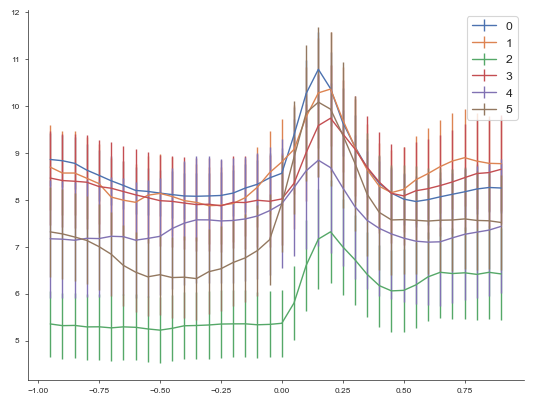

In [126]:
align_event = "feedback_times"
align_event = "stimOn_times"

n_units = sum([len(u) for k, u in units.items()])
extent = (tvec[0], tvec[-1], n_units, 0)
kwargs = dict(vmin=0, vmax=100, extent=extent, cmap='viridis')

conditions_df = pd.DataFrame(psths.keys(), columns=(*split_by, "align_event"))

# for plotting on a grid of unkown size
cond_x = np.sort(conditions_df[split_by[0]].unique())

for i, cond_a in enumerate(cond_x):
    try:
        x = tvec
        n_clusters = np.shape(psths[(cond_a, align_event)].T)[0]
        y = np.nanmean(psths[(cond_a, align_event)].T, axis=0)
        yerr = np.nanstd(psths[(cond_a,  align_event)].T, axis=0)/ np.sqrt(n_clusters)
        plt.errorbar(x, y, yerr, label=str(str(cond_a)))
    except KeyError:
        continue
plt.legend()


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_20891/2128401973.py:17: RuntimeWarning:

Mean of empty slice



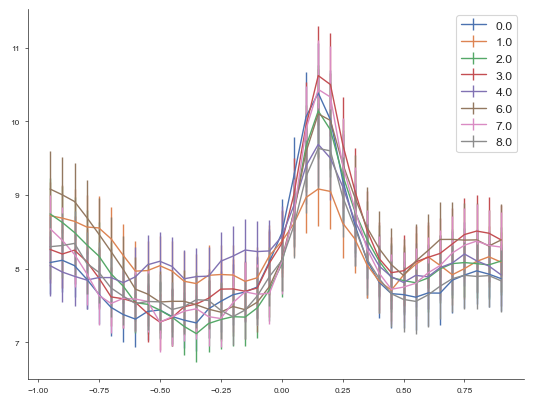

In [62]:
align_event = "feedback_times"
align_event = "stimOn_times"

n_units = sum([len(u) for k, u in units.items()])
extent = (tvec[0], tvec[-1], n_units, 0)
kwargs = dict(vmin=0, vmax=100, extent=extent, cmap='viridis')

conditions_df = pd.DataFrame(psths.keys(), columns=(*split_by, "align_event"))

# for plotting on a grid of unkown size
cond_x = np.sort(conditions_df[split_by[0]].unique())

for i, cond_a in enumerate(cond_x):
    try:
        x = tvec
        n_clusters = np.shape(psths[(cond_a, align_event)].T)[0]
        y = np.nanmean(psths[(cond_a, align_event)].T, axis=0)
        yerr = np.nanstd(psths[(cond_a,  align_event)].T, axis=0)/ np.sqrt(n_clusters)
        plt.errorbar(x, y, yerr, label=str(str(cond_a)))
    except KeyError:
        continue
plt.legend()


/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_20891/3422316290.py:6: RuntimeWarning:

Mean of empty slice

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning:

Degrees of freedom <= 0 for slice.



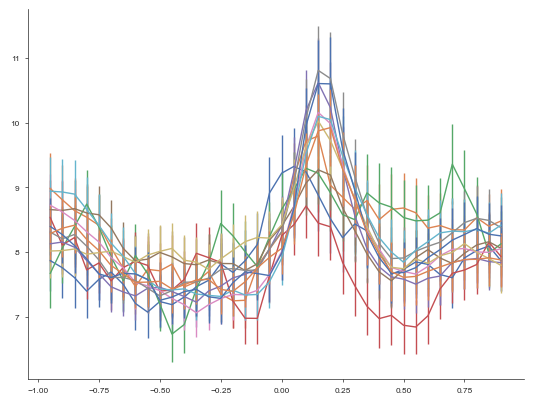

In [ ]:
for i, cond_a in enumerate(cond_x):
    for j, cond_b in enumerate(cond_y):
        try:
            x = tvec
            n_clusters = np.shape(psths[(cond_a, cond_b, align_event)].T)[0]
            y = np.nanmean(psths[(cond_a, cond_b, align_event)].T, axis=0)
            yerr = np.nanstd(psths[(cond_a, cond_b, align_event)].T, axis=0)/ np.sqrt(n_clusters)
            plt.errorbar(x, y, yerr, label=str(str(cond_a)+ str(cond_b)), label=)
            # axes[i, j].matshow(psths[(cond_a, cond_b, align_event)].T, **kwargs)
        except KeyError:
            continue

Text(0.5, 0.98, 'CA1 activity aligned on stimOn_times')

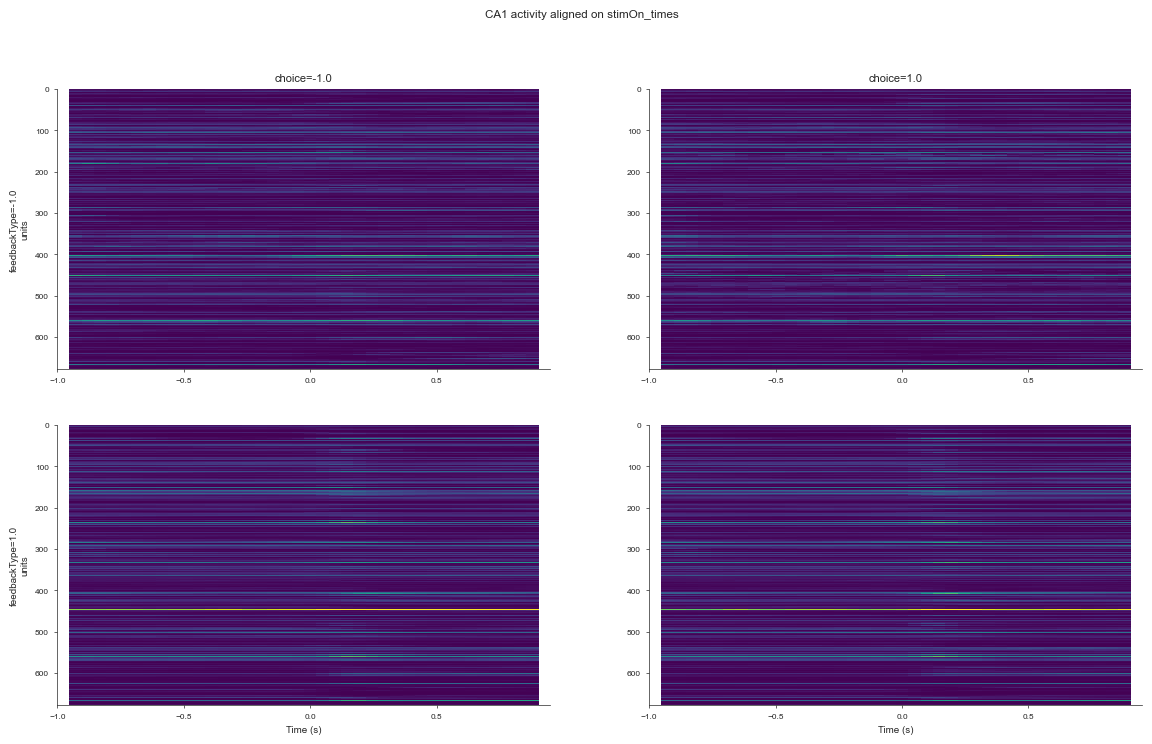

In [166]:
align_event = "feedback_times"
align_event = "stimOn_times"

n_units = sum([len(u) for k, u in units.items()])
extent = (tvec[0], tvec[-1], n_units, 0)
kwargs = dict(vmin=0, vmax=100, extent=extent, cmap='viridis')

conditions_df = pd.DataFrame(psths.keys(), columns=(*split_by, "align_event"))

# for plotting on a grid of unkown size
cond_x = np.sort(conditions_df[split_by[0]].unique())
cond_y = np.sort(conditions_df[split_by[1]].unique())

fig, axes = plt.subplots(nrows=len(cond_x), ncols=len(cond_y), figsize=[14,8])

for i, cond_a in enumerate(cond_x):
    for j, cond_b in enumerate(cond_y):
        try:
            axes[i, j].matshow(psths[(cond_a, cond_b, align_event)].T, **kwargs)
        except KeyError:
            continue

for ax in axes.flatten():
    ax.set_aspect("auto")
    import matplotlib.ticker as ticker

    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    ax.xaxis.set_ticks_position('bottom')

for i, ax in enumerate(axes[:, 0]):
    ax.set_ylabel(f"{split_by[0]}={cond_x[i]}\nunits")

for i, ax in enumerate(axes[0, :]):
    ax.set_title(f"{split_by[1]}={cond_y[i]}")

for i, ax in enumerate(axes[-1,:]):
    ax.set_xlabel('Time (s)')

fig.suptitle(f"{brain_region} activity aligned on {align_event}")

# RSA

In [153]:
np.shape(np.ravel(psths[condition]))[0]

26760

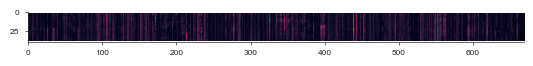

In [159]:
plt.imshow(psths[condition])

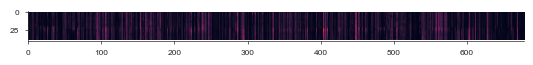

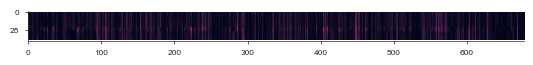

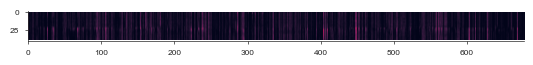

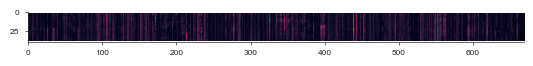

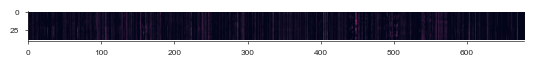

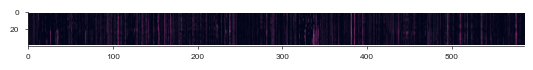

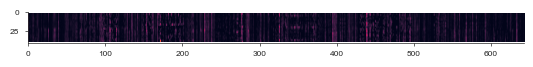

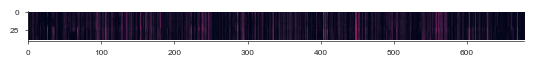

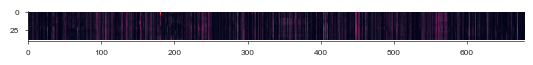

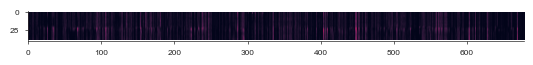

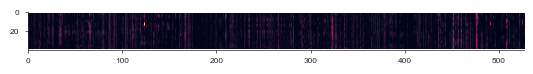

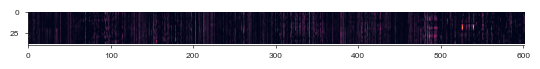

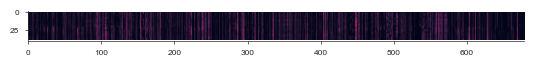

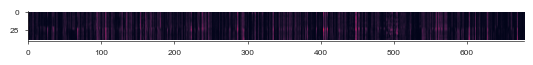

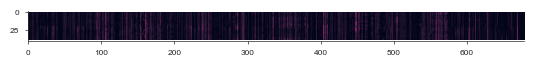

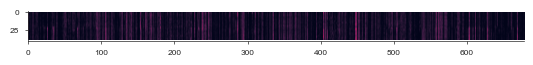

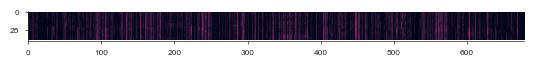

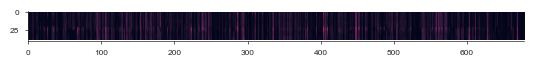

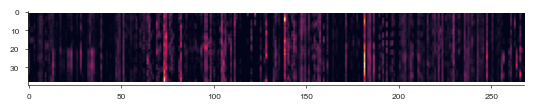

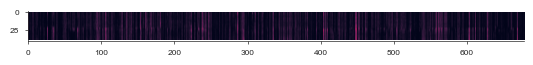

In [162]:
for c, condition in enumerate(conditions):
    plt.imshow(psths[condition])
    plt.show()

In [151]:
flattened = np.zeros((np.shape(np.ravel(psths[condition]))[0], len(conditions))) * np.nan
for c, condition in enumerate(conditions):
    flattened[:, c] = np.ravel(psths[condition])

    
from scipy.spatial.distance import pdist, squareform

X = flattened # shape (19000, 4)
X_clean = X[~np.isnan(X).any(axis=1)]

# Transpose so features become rows (4, 19000)
features = X_clean.T

# Pairwise Euclidean distances between the 4 feature-vectors
D = squareform(pdist(features, metric='euclidean'))

plt.imshow(D)


ValueError: could not broadcast input array from shape (26760,) into shape (27120,)

In [171]:
np.shape(X)

(152, 678)

In [167]:
from sklearn.decomposition import PCA
import plotly.express as px

align_event = "firstMovement_times"
align_event = "feedback_times"
align_event = "stimOn_times"

# cells are features
conditions_df = pd.DataFrame(psths.keys(), columns=(*split_by, "align_event"))
_conditions = conditions_df.groupby("align_event").get_group(align_event).values

# convert to 2d tuple
_conditions = tuple(tuple(row) for row in _conditions)

# combinding into a large matrix for PCA
# concatenate along the time axis. samples are time points, features are cells
X = np.concatenate([psths[cond] for cond in _conditions], axis=0)

# drop nans for pca (those were introduced by smoothing)
X = X[~np.any(np.isnan(X), axis=1)]

# compute the PCA (dimensionality reduction)
pca = PCA(n_components=3)
Xt = pca.fit_transform(X)

# split again into the indivdual conditions
psth_pca = dict(zip(_conditions, np.split(Xt, len(_conditions), axis=0)))

# gather the data for a 3d plot
dfs = []
for cond in _conditions:
    # contrast, outcome, _ = cond
    df = pd.DataFrame(psth_pca[cond], columns=['x','y','z'])
    if len(split_by)==2:
        label = f"{split_by[0]}={cond[0]},{split_by[1]}={cond[1]}"
    elif len(split_by)==1:
        label = f"{split_by[0]}={cond[0]}"
    df['cond'] = label
    dfs.append(df)

df = pd.concat(dfs, axis=0)

# 3d plot using plotly
fig = px.line_3d(df, x='x',y='y',z='z',color='cond')
fig.layout.scene.camera.projection.type = "orthographic"
fig.layout.dragmode = "turntable"
fig.show()

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [120]:
from sklearn.decomposition import PCA
import plotly.express as px

align_event = "firstMovement_times"
align_event = "feedback_times"
align_event = "stimOn_times"

# cells are features
conditions_df = pd.DataFrame(psths.keys(), columns=(*split_by, "align_event"))
_conditions = conditions_df.groupby("align_event").get_group(align_event).values

# convert to 2d tuple
_conditions = tuple(tuple(row) for row in _conditions)

# combinding into a large matrix for PCA
# concatenate along the time axis. samples are time points, features are cells
X = np.concatenate([psths[cond] for cond in _conditions], axis=0)

# drop nans for pca (those were introduced by smoothing)
X = X[~np.any(np.isnan(X), axis=1)]

# compute the PCA (dimensionality reduction)
pca = PCA(n_components=3)
Xt = pca.fit_transform(X)

# split again into the indivdual conditions
psth_pca = dict(zip(_conditions, np.split(Xt, len(_conditions), axis=0)))

# gather the data for a 3d plot
dfs = []
for cond in _conditions:
    # contrast, outcome, _ = cond
    df = pd.DataFrame(psth_pca[cond], columns=['x','y','z'])
    if len(split_by)==2:
        label = f"{split_by[0]}={cond[0]},{split_by[1]}={cond[1]}"
    elif len(split_by)==1:
        label = f"{split_by[0]}={cond[0]}"
    df['cond'] = label
    dfs.append(df)

df = pd.concat(dfs, axis=0)

# 3d plot using plotly
fig = px.line_3d(df, x='x',y='y',z='z',color='cond')
fig.layout.scene.camera.projection.type = "orthographic"
fig.layout.dragmode = "turntable"
fig.show()

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

